In [ ]:
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 15.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805891 sha256=4e3f372e9aef8f4d8cc4c1fcf407216e88502cf0133816dee5755ce80aba3f81
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


In [10]:
from pyspark.sql.functions import col, input_file_name, when, count
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


Task 1: Data Preprocessing (10%)


In [8]:

# Initialize Spark session
spark = SparkSession.builder.appName("PredictingLoans").getOrCreate()

# Defines the file path pattern to load both training and test datasets
# The wildcard * will match all CSV files in the loan dataset
path2loan = "/content/drive/MyDrive/set_loan/*.csv"

# Load the dataset from CSV files
loan_records_df = spark.read.option("header", "true").option("delimiter", ",").csv(path2loan)

# Display the first 10 rows of the loaded dataset
loan_records_df.show(10)

#Print the schema to display the data types of each column
loan_records_df.printSchema()


+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|                0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|             1508|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|                0|        66|             360|             1|        Urban|          Y

In [11]:
# Renaming columns to improve readability and maintain consistency
loan_records_df = loan_records_df.withColumnRenamed('ApplicantIncome', 'Applicant_Income') \
                                       .withColumnRenamed('CoapplicantIncome', 'Coapplicant_Income') \
                                       .withColumnRenamed('LoanAmount', 'Loan_Amount')

#  Convert numerical columns to the appropriate data types
# Convert Loan_Amount and Loan_Amount_Term to DoubleType for numerical operations
loan_records_df = loan_records_df.withColumn("Loan_Amount", col("Loan_Amount").cast(DoubleType()))
loan_records_df = loan_records_df.withColumn("Loan_Amount_Term", col("Loan_Amount_Term").cast(DoubleType()))

# Drop rows where 'Loan_Status' is missing
loan_records_df = loan_records_df.na.drop(subset=["Loan_Status"])

# Fill missing values in numerical columns with the median
# List of numerical columns to handle missing values
numerical_columns = ["Loan_Amount", "Loan_Amount_Term"]

for column in numerical_columns:
    # Calculate median for each numerical column
    median_value = loan_records_df.approxQuantile(column, [0.5], 0)[0]
    # Fill missing values in the column with the calculated median
    loan_records_df = loan_records_df.fillna({column: median_value})

# Define categorical columns to fill missing values with the mode
# List of categorical columns (including 'Credit_History') to handle missing values
categorical_columns = ["Gender", "Married", "Dependents", "Self_Employed", "Credit_History"]

for column in categorical_columns:
    # Calculate the mode for each categorical column
    mode_value = loan_records_df.groupBy(column).count().orderBy("count", ascending=False).first()[0]
    # Fill missing values in the column with the calculated mode
    loan_records_df = loan_records_df.fillna({column: mode_value})

# Check for missing values across all columns
# Display the count of missing values (nulls) for each column to show that all missing values have been handled
loan_records_df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in loan_records_df.columns]
).show()


+-------+------+-------+----------+---------+-------------+----------------+------------------+-----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|Applicant_Income|Coapplicant_Income|Loan_Amount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+----------------+------------------+-----------+----------------+--------------+-------------+-----------+
|      0|     0|      0|         0|        0|            0|               0|                 0|          0|               0|             0|            0|          0|
+-------+------+-------+----------+---------+-------------+----------------+------------------+-----------+----------------+--------------+-------------+-----------+



In [12]:
# Columns to encode
# List of categorical columns that need to be encoded
categorical_columns = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area", "Loan_Status"]

# Create StringIndexer transformations for categorical columns
# StringIndexer assigns an integer index to each category in a column
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Index").setHandleInvalid("skip") for col in categorical_columns]

# OneHotEncode the "Property_Area" column
# OneHotEncoder converts the indexed values to one-hot encoded vectors
encoders = [OneHotEncoder(inputCol="Property_Area_Index", outputCol="Property_Area_Vec")]

# Build the pipeline
# The pipeline is a sequence of transformations that will be applied in order
pipeline = Pipeline(stages=indexers + encoders)

# Apply the pipeline transformations to the dataset
loan_records_df = pipeline.fit(loan_records_df).transform(loan_records_df)

# Display a few rows to show that the columns have been encoded correctly
loan_records_df.select(
    "Gender_Index", "Married_Index", "Dependents_Index",
    "Education_Index", "Self_Employed_Index",
    "Property_Area_Vec", "Loan_Status_Index"
).show(5)

+------------+-------------+----------------+---------------+-------------------+-----------------+-----------------+
|Gender_Index|Married_Index|Dependents_Index|Education_Index|Self_Employed_Index|Property_Area_Vec|Loan_Status_Index|
+------------+-------------+----------------+---------------+-------------------+-----------------+-----------------+
|         0.0|          1.0|             0.0|            0.0|                0.0|    (2,[1],[1.0])|              0.0|
|         0.0|          0.0|             1.0|            0.0|                0.0|        (2,[],[])|              1.0|
|         0.0|          0.0|             0.0|            0.0|                1.0|    (2,[1],[1.0])|              0.0|
|         0.0|          0.0|             0.0|            1.0|                0.0|    (2,[1],[1.0])|              0.0|
|         0.0|          1.0|             0.0|            0.0|                0.0|    (2,[1],[1.0])|              0.0|
+------------+-------------+----------------+-----------

In [13]:
# Convert necessary columns to DoubleType
# Converting Applicant_Income, Coapplicant_Income, and Credit_History to numeric type (DoubleType)
loan_records_df = loan_records_df.withColumn("Applicant_Income", col("Applicant_Income").cast(DoubleType())) \
                                       .withColumn("Coapplicant_Income", col("Coapplicant_Income").cast(DoubleType())) \
                                       .withColumn("Credit_History", col("Credit_History").cast(DoubleType()))

# Show the schema to ensure the columns are of type Double
loan_records_df.printSchema()

# Split the dataset into training (70%) and testing (30%) sets
# Randomly split the data into training and test sets with a 70/30 split ratio
training_data, test_data = loan_records_df.randomSplit([0.7, 0.3], seed=42)

# Define input features for the model
# Excluding 'Loan_Status' and original categorical columns; including only transformed feature columns
feature_columns = ["Gender_Index", "Married_Index", "Dependents_Index",
                   "Education_Index", "Self_Employed_Index", "Applicant_Income",
                   "Coapplicant_Income", "Loan_Amount", "Loan_Amount_Term",
                   "Credit_History", "Property_Area_Vec"]

# Use VectorAssembler to combine feature columns into a single feature vector
# VectorAssembler is used to create a single vector of features for each row
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Apply VectorAssembler transformation to the training and test datasets
# Transform both the training and test datasets to add a 'features' column
training_data = assembler.transform(training_data).select("features", "Loan_Status_Index")
test_data = assembler.transform(test_data).select("features", "Loan_Status_Index")

# Show a few rows of the transformed training data with the 'features' column
print("Transformed Training Data:")
training_data.show(5)

# Show a few rows of the transformed test data with the 'features' column
print("Transformed Test Data:")
test_data.show(5)


root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- Applicant_Income: double (nullable = true)
 |-- Coapplicant_Income: double (nullable = true)
 |-- Loan_Amount: double (nullable = false)
 |-- Loan_Amount_Term: double (nullable = false)
 |-- Credit_History: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)
 |-- Gender_Index: double (nullable = false)
 |-- Married_Index: double (nullable = false)
 |-- Dependents_Index: double (nullable = false)
 |-- Education_Index: double (nullable = false)
 |-- Self_Employed_Index: double (nullable = false)
 |-- Property_Area_Index: double (nullable = false)
 |-- Loan_Status_Index: double (nullable = false)
 |-- Property_Area_Vec: vector (nullable = true)

Transformed Training Data:
+--

Task 2: Apply Classification Algorithms (30%)

Decision Tree Model Metrics:
Accuracy: 0.7468
Precision: 0.7740
Recall: 0.7468


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


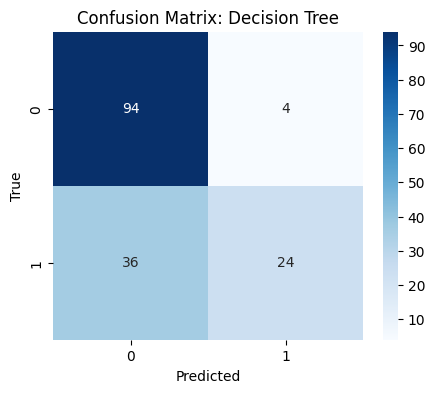

In [14]:

# Train the Decision Tree Classifier
# Initialize the Decision Tree model with label and feature columns
dt = DecisionTreeClassifier(labelCol="Loan_Status_Index", featuresCol="features")

# Fit the Decision Tree model on the training data
dt_model = dt.fit(training_data)

# Make predictions using the trained Decision Tree model
# Apply the trained model to the test dataset
dt_predictions = dt_model.transform(test_data)

# Evaluating the model's performance
# Initialize the evaluator for multi-class classification
evaluator = MulticlassClassificationEvaluator(labelCol="Loan_Status_Index", predictionCol="prediction")

# Calculating accuracy, precision, and recall for the model
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})

# Show the model's metrics
print("Decision Tree Model Metrics:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")

# Confusion Matrix for the Decision Tree model
# Convert the predictions and labels to an RDD
dt_preds_and_labels = dt_predictions.select("prediction", "Loan_Status_Index").rdd

# Initialize MulticlassMetrics to compute confusion matrix
dt_metrics = MulticlassMetrics(dt_preds_and_labels)

# Get the confusion matrix as a NumPy array
dt_confusion_matrix = dt_metrics.confusionMatrix().toArray()

# Plot the Confusion Matrix
# Set up the figure for the confusion matrix plot
plt.figure(figsize=(7, 6))

# Use heatmap to visualize the confusion matrix
sns.heatmap(dt_confusion_matrix, annot=True, fmt=".0f", cmap="Blues")

# Add title and axis labels
plt.title("Confusion Matrix: Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("True")

# Show the plot
plt.show()


Logistic Regression Model Metrics:
Accuracy: 0.7532
Precision: 0.8234
Recall: 0.7532


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


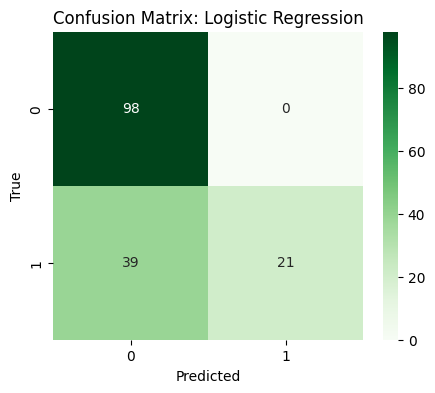

In [15]:
# Train the Logistic Regression model
# Initialize the Logistic Regression model with label and feature columns
lr = LogisticRegression(labelCol="Loan_Status_Index", featuresCol="features")

# Fit the Logistic Regression model on the training data
lr_model = lr.fit(training_data)

# Make predictions using the trained Logistic Regression model
# Apply the trained model to the test dataset
lr_predictions = lr_model.transform(test_data)

# Evaluate the model's performance
# Initialize the evaluator for multi-class classification
evaluator = MulticlassClassificationEvaluator(labelCol="Loan_Status_Index", predictionCol="prediction")

# Calculate accuracy, precision, and recall for the Logistic Regression model
lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})

# Show the model's metrics
print("Logistic Regression Model Metrics:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")

# Confusion Matrix for the Logistic Regression model
# Convert the predictions and labels to an RDD
lr_preds_and_labels = lr_predictions.select("prediction", "Loan_Status_Index").rdd

# Initialize MulticlassMetrics to compute the confusion matrix
lr_metrics = MulticlassMetrics(lr_preds_and_labels)

# Get the confusion matrix as a NumPy array
lr_confusion_matrix = lr_metrics.confusionMatrix().toArray()

# Plot the Confusion Matrix
# Set up the figure for the confusion matrix plot
plt.figure(figsize=(7, 6))

# Use heatmap to visualize the confusion matrix
sns.heatmap(lr_confusion_matrix, annot=True, fmt=".0f", cmap="Greens")

# Add title and axis labels
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")

# Show the plot
plt.show()

Task 3: Model Comparison (10%)

Model Comparison Table Metrics (Accuracy, Precision, Recall):
| Model               |   Accuracy |   Precision |   Recall |
|:--------------------|-----------:|------------:|---------:|
| Decision Tree       |   0.746835 |    0.773988 | 0.746835 |
| Logistic Regression |   0.753165 |    0.823432 | 0.753165 |


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


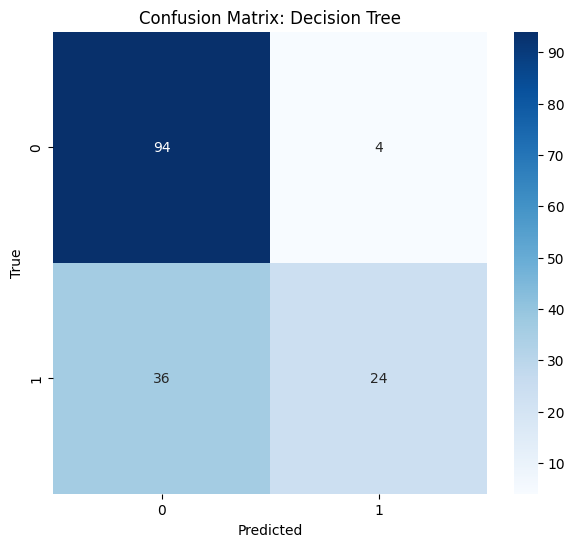

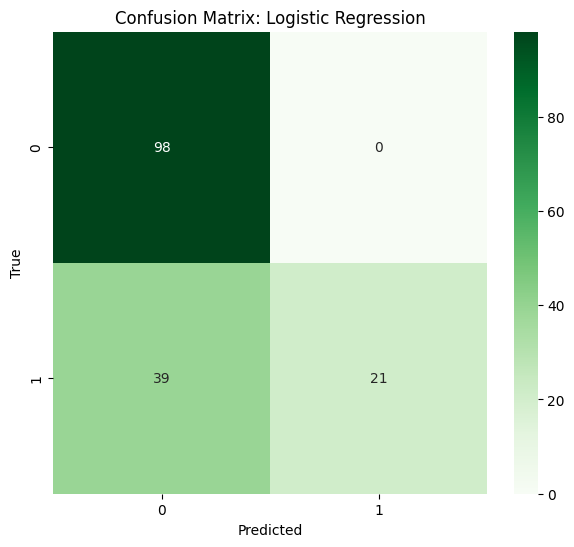

In [17]:
#Heatmaps + Model comparsion table

# Train Decision Tree model
dt = DecisionTreeClassifier(labelCol="Loan_Status_Index", featuresCol="features")
dt_model = dt.fit(training_data)

# Make predictions with Decision Tree
dt_predictions = dt_model.transform(test_data)

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Loan_Status_Index", predictionCol="prediction")

# Calculate metrics for Decision Tree
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})


# Train Logistic Regression model
lr = LogisticRegression(labelCol="Loan_Status_Index", featuresCol="features")
lr_model = lr.fit(training_data)

# Make predictions with Logistic Regression
lr_predictions = lr_model.transform(test_data)

# Calculate metrics for Logistic Regression
lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})


# Combine the metrics for both models
metrics_data = {
    "Model": ["Decision Tree", "Logistic Regression"],
    "Accuracy": [dt_accuracy, lr_accuracy],
    "Precision": [dt_precision, lr_precision],
    "Recall": [dt_recall, lr_recall]
}

# Convert metrics to a DataFrame for display
metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index("Model")

# Display the model comparison table (accuracy, precision, recall)
print("Model Comparison Table Metrics (Accuracy, Precision, Recall):")
print(metrics_df.to_markdown(index=True))


# Confusion Matrix for Decision Tree
dt_preds_and_labels = dt_predictions.select("prediction", "Loan_Status_Index").rdd
dt_metrics = MulticlassMetrics(dt_preds_and_labels)
dt_confusion_matrix = dt_metrics.confusionMatrix().toArray()

# Confusion Matrix for Logistic Regression
lr_preds_and_labels = lr_predictions.select("prediction", "Loan_Status_Index").rdd
lr_metrics = MulticlassMetrics(lr_preds_and_labels)
lr_confusion_matrix = lr_metrics.confusionMatrix().toArray()

# Plot Decision Tree Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(dt_confusion_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix: Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot Logistic Regression Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(lr_confusion_matrix, annot=True, fmt=".0f", cmap="Greens")
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()